In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
from misc import preprocessing, normalization
import pandas as pd

In [2]:

#Read data
model_name = 'P1C1_s'
dataset_name = 'P1C1_s'
theta = 0
ndata, I1, I2, I4a, I4s, Psi_gt, X, Y, sigma_gt, F, C, C_inv  = preprocessing(dataset_name)
meanPsi, meanI1, meanI2, meanI4a, meanI4s, stdPsi, stdI1, stdI2, stdI4a, stdI4s = normalization(True, model_name, Psi_gt, I1, I2, I4a, I4s)

I4a = np.clip(I4a, a_min=1.0, a_max=None)
I4s = np.clip(I4s, a_min=1.0, a_max=None)

Psinorm = (Psi_gt - meanPsi)/stdPsi
I1norm  = (I1     - meanI1) /stdI1
I2norm  = (I2     - meanI2) /stdI2
I4anorm = (I4a    - meanI4a)/stdI4a
I4snorm = (I4s    - meanI4s)/stdI4s

#### Combine the NN inputs
inputs = np.array([I1norm, I2norm, I4anorm, I4snorm]).transpose()
inpten = tf.Variable(inputs)

#Load the model
model_fname   = 'savednet/'+model_name+'.json'
weights_fname = 'savednet/'+model_name+'_weights.h5'
model = tf.keras.models.model_from_json(open(model_fname).read())
model.load_weights(weights_fname)

#Make predictions
y_pred = model(inputs)
Psi_pr = y_pred[:,0]*stdPsi + meanPsi
d1 = y_pred[:,1]**2*stdPsi/stdI1
d2 = y_pred[:,2]**2*stdPsi/stdI2
d3 = y_pred[:,3]**2*stdPsi/stdI4a
d4 = y_pred[:,4]**2*stdPsi/stdI4s

sigma_pr = np.zeros_like(C)
a0 = np.array([ np.cos(theta), np.sin(theta), 0])
s0 = np.array([-np.sin(theta), np.cos(theta), 0])
a0a0 = np.outer(a0,a0)
s0s0 = np.outer(s0,s0)
p = -(2*d1[:] + 2*d2[:]*(I1-C[:,2,2]))*C[:,2,2]
I1_2 = np.zeros_like(C)
for i in range(ndata):
    I1_2[i,:,:] = I1[i]*np.eye(3)
    sigma_pr[i,:,:] = 2*d1[i]*np.eye(3) + 2*d2[i]*(I1_2[i,:,:]-C[i,:,:]) 
    sigma_pr[i,:,:]+= 2*d3[i]*a0a0[:,:] + 2*d4[i]*s0s0[:,:] + p[i]*C_inv[i,:,:]
    sigma_pr[i,:,:] = F[i,:,:]*sigma_pr[i,:,:]*F[i,:,:]

#Read fitting history:
with open('savednet/'+model_name+'_history.pkl', 'rb') as f:
    [total_loss, sigma_loss, symmetry_loss, convexity_loss, Psi_loss] = pickle.load(f)

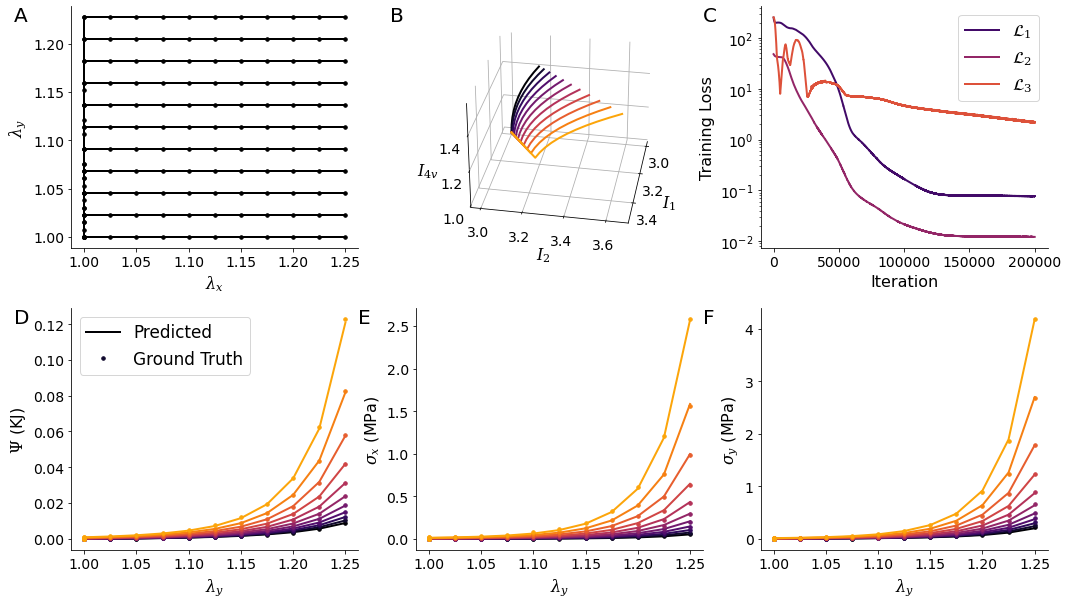

In [3]:
fsize=10
pltparams = {'legend.fontsize': 'large',
          'figure.figsize': (fsize*1.75,fsize),
          'font.size'     : 1.4*fsize,
          'axes.labelsize': 1.6*fsize,
          'axes.titlesize': 1.4*fsize,
          'xtick.labelsize': 1.4*fsize,
          'ytick.labelsize': 1.4*fsize,
          'lines.linewidth': 2,
          'lines.markersize': 7,
          'axes.titlepad': 25,
          "mathtext.fontset": 'dejavuserif',
          'axes.labelpad': 5}
plt.rcParams.update(pltparams)
res1 = 11
res2 = 4
res3 = 11
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.inferno(np.linspace(0, 0.8,res1)))

fig = plt.figure()
gs = fig.add_gridspec(2,3, wspace=0.2, hspace=0.25) #nrows, ncols

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], projection = '3d')
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])
for i in range(res1):
    i1 = i*(res2+res3)
    i2 = (i+1)*(res2+res3)
    ax1.plot(X[i1:i2,1], X[i1:i2,0],'.-', color='k')
    ax2.plot(I1[i1:i2], I2[i1:i2], I4s[i1:i2])

bottomrow = [ax4, ax5, ax6]
y_prs = [Psi_pr, sigma_pr[:,0,0], sigma_pr[:,1,1]]
y_gts = [Psi_gt, sigma_gt[:,0,0], sigma_gt[:,1,1]]
for ax,y_pr,y_gt in zip(bottomrow,y_prs,y_gts):
    for i in range(res1):
        i1 = i*(res2+res3)
        i2 = (i+1)*(res2+res3)
        ax.plot(X[i1:i2,1], y_pr[i1:i2])
    for i in range(res1):
        i1 = i*(res2+res3)
        i2 = (i+1)*(res2+res3)
        ax.plot(X[i1:i2,1], y_gt[i1:i2],'.')

#The Psi panel needs special treatment due to the presence of the legend.i1 = 0
i2 = res2+res3
ax4.plot(X[i1:i2,1], Psi_pr[i1:i2], label = 'Predicted')
ax4.plot(X[i1:i2,1], Psi_gt[i1:i2],'.', label = 'Ground Truth')
ax4.legend()

#Format the 3D panel
ax2.set(xlabel = '$I_1$', ylabel = '$I_2$', zlabel = '$I_{4v}$')
ax2.view_init(azim=10)
ax2.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax2.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax2.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax2.xaxis.set_rotate_label(False)
ax2.yaxis.set_rotate_label(False)
ax2.zaxis.set_rotate_label(False)
ax2.text2D(-0.20,1.0, 'B', transform=ax2.transAxes, va='top', fontsize=20)

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.inferno(np.linspace(0.2, 0.8, 4)))
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(Psi_loss,   label = '$\\mathcal{L}_1$')
ax3.plot(sigma_loss, label = '$\\mathcal{L}_2$')
ax3.plot(symmetry_loss+convexity_loss,  label = '$\\mathcal{L}_3$')
ax3.set(yscale = 'log', xscale='linear')
ax3.legend()

#Format all panels except the 3d panel
axi = [ax1, ax3, ax4, ax5, ax6]
labels = ['A', 'C', 'D', 'E', 'F']
xlabels = ['$\\lambda_x$', 'Iteration', '$\\lambda_y$', '$\\lambda_y$', '$\\lambda_y$']
ylabels = ['$\\lambda_y$', 'Training Loss', '$\\Psi$ (KJ)', '$\\sigma_x$ (MPa)', '$\\sigma_y$ (MPa)']
for ax,label,xlabel,ylabel in zip(axi,labels,xlabels,ylabels):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(-0.20,1.0, label, transform=ax.transAxes, va='top', fontsize=20)
    ax.set(xlabel=xlabel, ylabel=ylabel)

fig.savefig('figs/fig_synthetic.jpg')

## Save pgfplots data

In [4]:
data = X[:,0].reshape([11,15])
data = np.vstack([X[:15,1], data])
header = ['x']
for i in range(11):
    header.append('y'+str(i))
df = pd.DataFrame(data.T, columns=header)
df.to_csv('tikz_data/fig_synthetic_data/fig_synthetic_A.csv', index=False, sep=' ')

In [5]:
data = np.vstack([I1.reshape([11,15]), I2.reshape([11,15]), I4a.reshape([11,15]), I4s.reshape([11,15])])
header = []
for i in range(11):
    header.append('I1_'+str(i))
for i in range(11):
    header.append('I2_'+str(i))
for i in range(11):
    header.append('I4v_'+str(i))
for i in range(11):
    header.append('I4w_'+str(i))
df = pd.DataFrame(data.T, columns=header)
df.to_csv('tikz_data/fig_synthetic_data/fig_synthetic_B.csv', index=False, sep=' ')

In [6]:
ndata = Psi_loss.shape[0]
for i in range(ndata):
    Psi_loss[i] = np.max([Psi_loss[i],0])
data = np.vstack([np.linspace(1,ndata,ndata), Psi_loss, sigma_loss, symmetry_loss+convexity_loss])
data = data[:,0::100]
header = ['iter', 'L1', 'L2', 'L3']
df = pd.DataFrame(data.T, columns=header)
df.to_csv('tikz_data/fig_synthetic_data/fig_synthetic_C.csv', index=False, sep=' ')

In [7]:
data = np.vstack([X[:15,1], Psi_pr.numpy().reshape([11,15]), Psi_gt.reshape([11,15])])
header = ['lambda']
for i in range(11):
    header.append('pr_'+str(i))
for i in range(11):
    header.append('gt_'+str(i))
df = pd.DataFrame(data.T, columns=header)
df.to_csv('tikz_data/fig_synthetic_data/fig_synthetic_D.csv', index=False, sep=' ')

In [8]:
data = np.vstack([X[:15,1], sigma_pr[:,0,0].reshape([11,15]), sigma_gt[:,0,0].reshape([11,15])])
header = ['lambda']
for i in range(11):
    header.append('pr_'+str(i))
for i in range(11):
    header.append('gt_'+str(i))
df = pd.DataFrame(data.T, columns=header)
df.to_csv('tikz_data/fig_synthetic_data/fig_synthetic_E.csv', index=False, sep=' ')

In [9]:
data = np.vstack([X[:15,1], sigma_pr[:,1,1].reshape([11,15]), sigma_gt[:,1,1].reshape([11,15])])
header = ['lambda']
for i in range(11):
    header.append('pr_'+str(i))
for i in range(11):
    header.append('gt_'+str(i))
df = pd.DataFrame(data.T, columns=header)
df.to_csv('tikz_data/fig_synthetic_data/fig_synthetic_F.csv', index=False, sep=' ')